In [ ]:
import json

with open('/Users/kriskasira/Documents/RiProject/archive/Batch 3/import-videos/ann/instances.json', 'r') as file:
    podaci = json.load(file)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kriskasira/Documents/RiProject/archive/Batch 3/import-videos/ann/instances.json'

In [20]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
cd drive/MyDrive/panoptic

/content/drive/.shortcut-targets-by-id/1i1O5IzicKZOnN9ws7xZ6NJuTmO6MumG4/panoptic


In [3]:
!pip install pycocotools

In [4]:
!pip install torchmetrics

## Pregled Podataka

In [ ]:
pwd

'/content/drive/.shortcut-targets-by-id/1i1O5IzicKZOnN9ws7xZ6NJuTmO6MumG4/panoptic'

In [ ]:
!ls codes/utils/

utils.py


In [5]:
import torch
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
from PIL import Image
import cv2
from pycocotools.coco import COCO
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as T
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models import ResNet50_Weights
from codes.utils.utils import plot_object_distribution, set_seed

In [6]:
TRAIN_ANNOTATION = './archive/training_and_validation/train.json'
VAL_ANNOTATION = './archive/training_and_validation/val.json'
TEST_ANNOTATION = './archive/test/import-videos/ann/instances.json'
IMAGES_DIR = './archive/images/'
MODEL_DIR_PATH = './output/mask_rcnn_models/'

In [7]:
NUM_CLASSES = 8
set_seed(42)

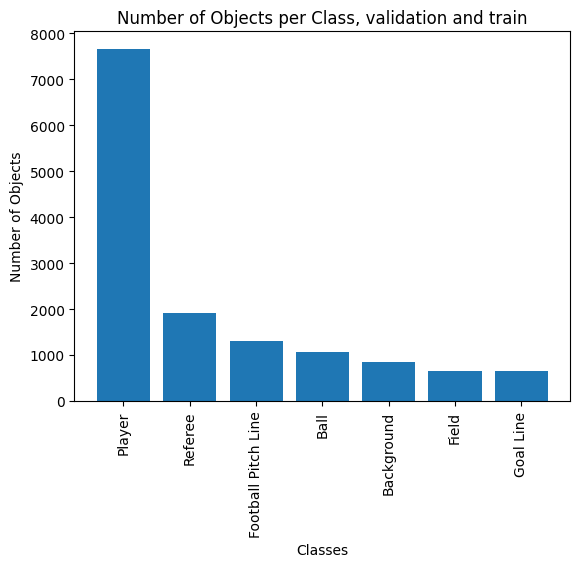

In [8]:
plot_object_distribution(TRAIN_ANNOTATION, title = "Number of Objects per Class, validation and train")

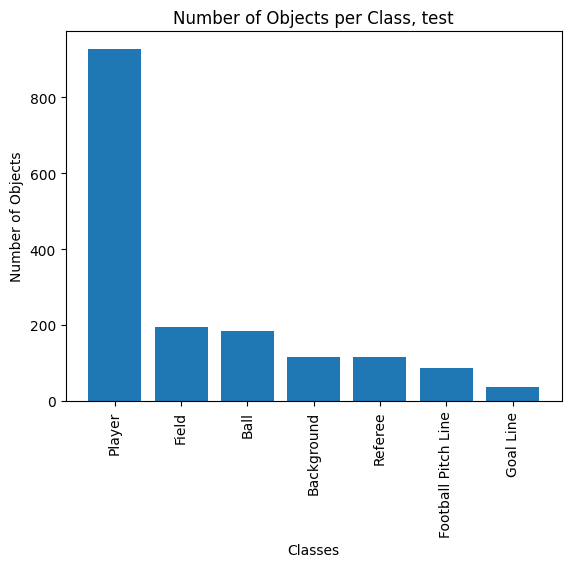

In [ ]:
plot_object_distribution(TEST_ANNOTATION, "Number of Objects per Class, test")

## Definisanje modela

In [8]:
class CustomDataset(Dataset):
    def __init__(self, root, annotation_files, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco_datasets = [COCO(annotation_file) for annotation_file in annotation_files]
        self.img_ids = []
        for coco in self.coco_datasets:
            self.img_ids.extend(list(coco.imgs.keys()))
        self.img_ids = list(set(self.img_ids))


    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        for coco in self.coco_datasets:
            if img_id in coco.imgs:
                img_info = coco.loadImgs(img_id)[0]
                ann_ids = coco.getAnnIds(imgIds=img_id)
                anns = coco.loadAnns(ann_ids)
                break

        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        masks = []
        areas = []

        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])
            mask = coco.annToMask(ann)
            masks.append(mask)
            areas.append(ann['area'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.stack(masks), dtype=torch.uint8)
        areas = torch.as_tensor(areas, dtype=torch.float32)

        image_id = torch.tensor([img_id])
        iscrowd = torch.as_tensor([ann.get('iscrowd', 0) for ann in anns], dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = areas
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.img_ids)

def get_instance_segmentation_model(num_classes):
    backbone = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    backbone = torch.nn.Sequential(*(list(backbone.children())[:-2]))
    backbone.out_channels = 2048

    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),) * 5
    )

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'], output_size=7, sampling_ratio=2
    )

    model = MaskRCNN(backbone,
                     num_classes=num_classes,
                     rpn_anchor_generator=anchor_generator,
                     box_roi_pool=roi_pooler)

    return model

In [9]:
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def evaluate(model, data_loader, device, num_classes = NUM_CLASSES, testing = False):
    model.to(device)
    total_loss = 0.0
    num_batches = 0
    map_bbox = MeanAveragePrecision(iou_type="bbox", class_metrics=True)
    mAP_classes_res = None

    if testing:
      map_70 = MeanAveragePrecision(iou_thresholds=[0.7, 0.8, 0.9], class_metrics=True)

    with torch.no_grad():
        for images, targets in data_loader:
            model.train()
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images, targets)


            loss_dict = outputs
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
            num_batches += 1

            model.eval()
            outputs = model(images)


            for i, output in enumerate(outputs):

                preds = [{
                    'boxes': outputs[i]['boxes'].cpu(),
                    'scores': outputs[i]['scores'].cpu(),
                    'labels': outputs[i]['labels'].cpu(),
                }]

                gts = [{
                    'boxes': targets[i]['boxes'].cpu(),
                    'labels': targets[i]['labels'].cpu(),
                }]

                map_bbox.update(preds, gts)

                if testing:
                      map_70.update(preds, gts)

    mean_loss = total_loss / num_batches if num_batches > 0 else float('nan')
    mAP_bbox_res = map_bbox.compute()

    if testing:
      mAP_70_res = map_70.compute()

    return mean_loss, mAP_bbox_res, mAP_70_res

## Treniranje i testiranje modela

In [10]:
def train(model, train_loader, val_loader, optimizer, lr_scheduler, num_epochs = 5):
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    device = 'cuda'

    train_losses = []
    val_losses = []
    map_values_bbox = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        for images, targets in train_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            running_loss += losses.item()

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch loss: {epoch_loss}")
        train_losses.append(epoch_loss)

        val_epoch_loss, val_mAP_bbox, _ = evaluate(model, val_loader, device)
        val_mAP_bbox = val_mAP_bbox['map']
        print(f"Validation loss: {val_epoch_loss}\nValidation bbox mAP: {val_mAP_bbox}")

        map_values_bbox.append(val_mAP_bbox)

        val_losses.append(val_epoch_loss)
        lr_scheduler.step()

    print("Training complete")
    return model, train_losses, val_losses, map_values_bbox

In [11]:
def test(model, device, data_path, annotation_paths):
    dataset = CustomDataset(data_path, annotation_paths, transforms=T.Compose([T.ToTensor()]))
    data_loader = DataLoader(dataset, batch_size=2, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

    mean_loss, mAP, mAP_classes = evaluate(model, data_loader, device)

In [12]:
def plot_losses(train_losses, val_losses):
    epochs = [i for i in range(1, len(val_losses)+1)]

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Training Loss', marker='o', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs - MASK RCNN')
    plt.legend()
    plt.grid(True)
    plt.xticks(epochs)
    plt.show()

In [13]:
# training and validation data
train_dataset = CustomDataset(IMAGES_DIR, [
    TRAIN_ANNOTATION
], transforms=T.Compose([T.ToTensor()]))

val_dataset = CustomDataset(IMAGES_DIR, [
    VAL_ANNOTATION
], transforms=T.Compose([T.ToTensor()]))

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.65s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [14]:
model = get_instance_segmentation_model(NUM_CLASSES)
model.to('cpu')

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 5

In [21]:
evaluate(model, val_loader, 'cpu')

KeyboardInterrupt: 

In [ ]:
model, train_losses, val_losses, map_values_bbox  = train(model, train_loader, val_loader, optimizer, lr_scheduler, num_epochs)

Epoch 1/5
Epoch loss: 1.453364244671095


TypeError: list indices must be integers or slices, not str

In [ ]:
from codes.utils.utils import save_model

save_model(
    model,
    optimizer,
    val_losses,
    train_losses,
    optimizer.param_groups[0]['lr'],
    num_epochs,
    train_loader.batch_size,
    str(model),
    MODEL_DIR_PATH,
    len(train_loader.dataset),
    len(val_loader.dataset),
    [tensor.item() if tensor.numel() == 1 else tensor.tolist() for tensor in map_values_bbox],
    'mask_rcnn_test',
    optimizer_hyperparameters=str(optimizer.defaults)
)

Metapodaci sačuvani u: ./output/mask_rcnn_models/.json


NameError: name 'torch' is not defined

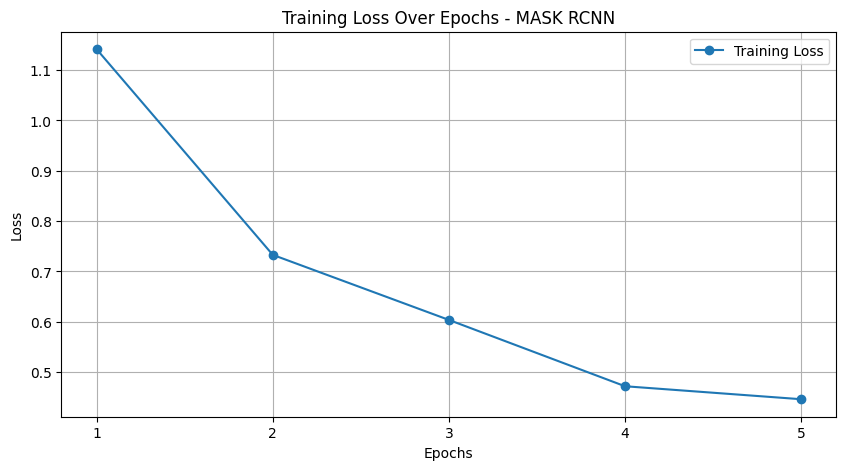

In [ ]:
plot_losses(train_losses, val_losses)

In [ ]:
test(model, 'cuda', data_path=IMAGES_DIR, annotation_paths=[TEST_ANNOTATION])

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(6, 1080, 1920)
(2, 1, 1080, 1920)


ValueError: shapes (2,2160) and (6480,6) not aligned: 2160 (dim 1) != 6480 (dim 0)

## Predikcije na novim slikama

In [ ]:
categories = {
    1: "Player",
    2: "Ball",
    3: "Goal Line",
    4: "Field",
    5: "Background",
    6: "Referee",
    7: "Football Pitch Line",
}

# setting model priorities for properly mask drawing
priorities = {
    1 : 6, # player
    2 : 7, # ball
    3 : 4, # goal line
    4 : 2, # field
    5 : 1, # background
    6 : 5, # refree
    7 : 3, # pitch line
    0 : 0
}

In [ ]:
def load_model(model_path, num_classes):
    model = get_instance_segmentation_model(num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def predict(model, image_path, device):
    image = Image.open(image_path).convert("RGB")

    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        prediction = model(image_tensor.to(device))

    return image, prediction

In [ ]:
model = load_model(MODEL_DIR_PATH + 'mask_rcnn_1', 8)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn

In [ ]:
def set_priorities(prediction, priorities):
    predictions_with_priorities = []
    for element in range(len(prediction[0]['boxes'])):
        box = prediction[0]['boxes'][element].cpu().numpy()
        score = prediction[0]['scores'][element].cpu().numpy()
        label_id = int(prediction[0]['labels'][element].cpu().numpy())
        mask = prediction[0]['masks'][element, 0].cpu().numpy()
        priority = priorities.get(label_id, 0)
        predictions_with_priorities.append((priority, box, score, label_id, mask))

    predictions_with_priorities.sort(key=lambda x: x[0])
    return predictions_with_priorities

def predict_and_visualize(image_path, model, device, draw_mask = True, draw_box = True):

    image, prediction = predict(model, image_path, device)

    predictions_with_priorities = set_priorities(prediction, priorities)

    combined_mask = np.zeros_like(image, dtype=np.float32)

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    if draw_mask:
        for priority, box, score, label_id, mask in predictions_with_priorities:
            label = categories.get(label_id, 'Unknown')

            if score > 0.5:
                mask = mask > 0.5
                random_color = np.random.rand(3)
                colored_mask = np.zeros((*mask.shape, 3))
                colored_mask[mask] = random_color
                combined_mask[mask] = random_color


        combined_mask = np.clip(combined_mask, 0, 1)
        ax.imshow(combined_mask, alpha=0.5)

    if draw_box:
        for priority, box, score, label_id, mask in predictions_with_priorities:
            label = categories.get(label_id, 'Unknown')

            if score > 0.5:
                rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(box[0], box[1] - 10, f'{label}: {score:.2f}', color='red', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

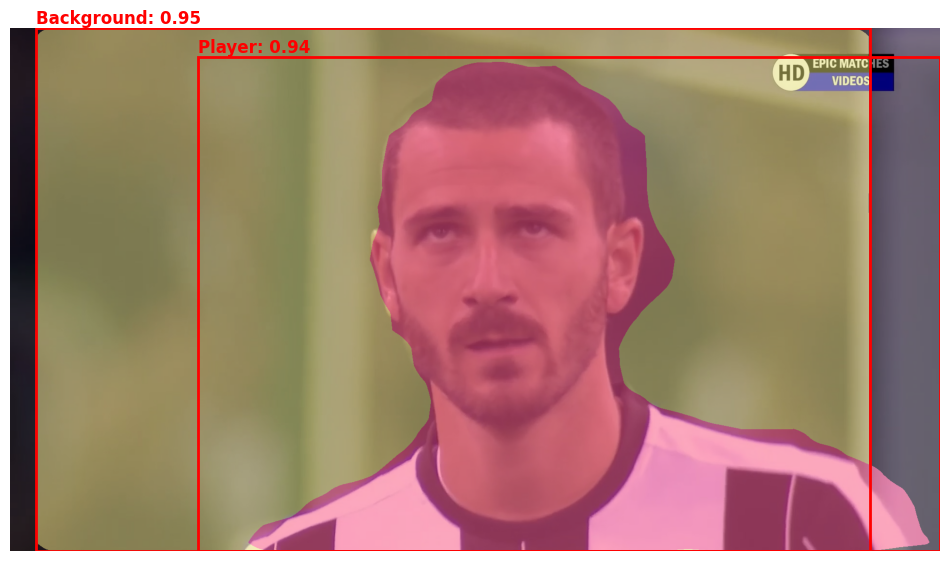

In [ ]:
predict_and_visualize("./archive/images/Football batch 1.mp4_00001.jpg", model, device, draw_box=True, draw_mask=True)

## Prosirivanje skupa podataka

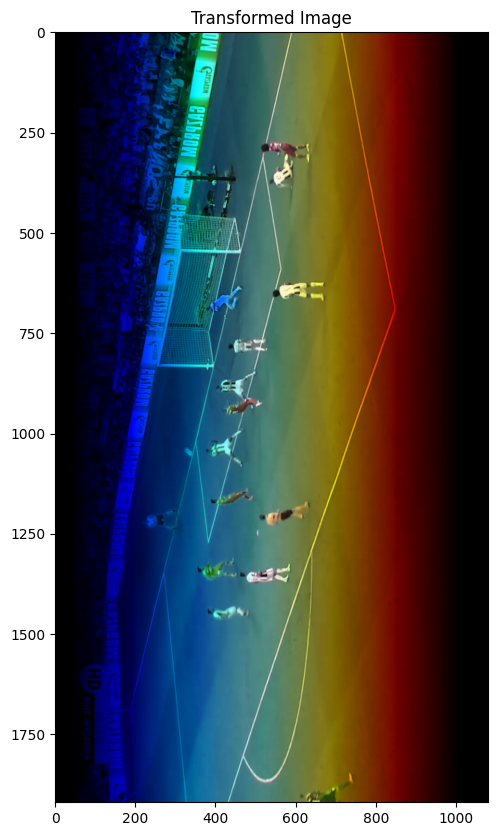

In [19]:
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import torch

geom_transforms =  [A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15,
                       interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=0.5),
                    # D4 Group augmentations
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.RandomRotate90(p=0.5),
                    A.Transpose(p=0.5)]
augs = A.Compose(geom_transforms, p=1)

img, target = train_dataset[0]

# Pretpostavljam da već imaš numpy array iz img
transformed = augs(image=np.array(img))

# Sada ručno konvertuj sliku u tensor i permutuj dimenzije
transformed_img = torch.tensor(transformed['image']).permute(2, 0, 1)

# Prebaci tensor iz oblika (channels, height, width) u (height, width, channels) za prikaz
transformed_img_np = transformed_img.permute(0, 2, 1).cpu().numpy()

# Prikaz slike koristeći matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(transformed_img_np)
plt.title('Transformed Image')
plt.show()


In [36]:
print("Shape of transformed image (numpy):", transformed_img_np.shape)

Shape of transformed image (numpy): (1920, 1080, 3)


In [19]:
# Dohvati prvi element iz dataset-a bez primene transformacija
img, target = train_dataset[0]

# Primeni transformaciju na sliku i anotacije
transformed = transform(image=np.array(img))

# Prikaži transformisanu sliku
transformed_img = transformed['image'].permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=(10, 10))
plt.imshow(transformed_img)
plt.title('Transformed Image')
plt.show()

# Prikaži transformisanu masku
plt.figure(figsize=(10, 10))
plt.imshow(transformed['mask'], cmap='gray')
plt.title('Transformed Mask')
plt.show()

# Ispis transformisanih bounding box-ova i labela
print(f"Transformed Bounding Boxes: {transformed['bboxes']}")
print(f"Transformed Labels: {transformed['category_ids']}")

AttributeError: 'numpy.ndarray' object has no attribute 'permute'

In [ ]:
import os
import cv2
import json

def save_augmented_dataset(train_dataset, transform, output_image_dir='extended_images', output_annotation_file='extended_annotations.json'):
    os.makedirs(output_image_dir, exist_ok=True)

    annotations = {
        "images": [],
        "annotations": [],
        "categories": []  # Dodaj ovde kategorije ako već nisu definisane
    }

    image_id = 0
    annotation_id = 0

    for i, sample in enumerate(train_dataset):
        image = sample['image'].permute(1, 2, 0).cpu().numpy()  # Transform image back to HWC format
        bboxes = sample['bboxes']
        mask = sample['mask'].cpu().numpy()
        category_ids = sample['category_ids']

        # Sačuvaj originalnu sliku
        image_path = os.path.join(output_image_dir, f'image_{image_id}.png')
        cv2.imwrite(image_path, image)

        # Dodaj informaciju o originalnoj slici u anotacije
        image_info = {
            "id": image_id,
            "file_name": f'image_{image_id}.png',
            "height": image.shape[0],
            "width": image.shape[1]
        }
        annotations["images"].append(image_info)

        # Dodaj originalne bounding boxove u anotacije
        for bbox, category_id in zip(bboxes, category_ids):
            annotation_info = {
                "image_id": image_id,
                "bbox": bbox,
                "category_id": category_id,
                "id": annotation_id,
                "segmentation": []  # Dodaj poligonalne anotacije za maske ako je potrebno
            }
            annotations["annotations"].append(annotation_info)
            annotation_id += 1

        image_id += 1

        # Sada primeni transformaciju i sačuvaj augmentovanu sliku
        augmented = transform(image=image, bboxes=bboxes, mask=mask, category_ids=category_ids)
        augmented_image = augmented['image'].permute(1, 2, 0).cpu().numpy()
        augmented_bboxes = augmented['bboxes']
        augmented_mask = augmented['mask'].cpu().numpy()
        augmented_category_ids = augmented['category_ids']

        # Sačuvaj augmentovanu sliku
        augmented_image_path = os.path.join(output_image_dir, f'image_{image_id}.png')
        cv2.imwrite(augmented_image_path, augmented_image)

        # Dodaj informaciju o augmentovanoj slici u anotacije
        augmented_image_info = {
            "id": image_id,
            "file_name": f'image_{image_id}.png',
            "height": augmented_image.shape[0],
            "width": augmented_image.shape[1]
        }
        annotations["images"].append(augmented_image_info)

        # Dodaj augmentovane bounding boxove u anotacije
        for bbox, category_id in zip(augmented_bboxes, augmented_category_ids):
            augmented_annotation_info = {
                "image_id": image_id,
                "bbox": bbox,
                "category_id": category_id,
                "id": annotation_id,
                "segmentation": []  # Dodaj poligonalne anotacije za maske ako je potrebno
            }
            annotations["annotations"].append(augmented_annotation_info)
            annotation_id += 1

        image_id += 1

    # Sačuvaj sve anotacije u jedan JSON fajl
    with open(output_annotation_file, 'w') as f:
        json.dump(annotations, f)

    print(f"Sve originalne i augmentovane slike su sačuvane u '{output_image_dir}', a anotacije u '{output_annotation_file}'.")

